In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import SimultaneousActivation
import random

# Agentes

In [2]:
class Item(Agent):
    def __init__(self, model, item_type, pontos):
        super().__init__(model)
        self.type = item_type
        self.pontos = pontos
        self.carregado_por = []

    def step(self):
        pass

In [7]:
class ReativoSimples(Agent):
    def __init__(self, model):
        super().__init__(model)
        self.has_item = False
        self.item = None
        self.contribuicao = 0

    def pegar_item(self, item):
        if item.type == "Cristal Energético" or item.type == "Metal Raro":
            self.has_item = True
            self.item = item
            item.carregado_por = [self]

        elif item.type == "Estrutura Antiga" and len(item.carregado_por) < 2:
            item.carregado_por.append(self)
            if len(item.carregado_por) == 2:
                for agent in item.carregado_por:
                    agent.has_item = True
                    agent.item = item

    def entregar_item(self):
        if self.item:
            self.contribuicao += self.item.pontos
            #if self.item.type == "Cristal Energético" or self.item.type == "Metal Raro":
            
            self.has_item = False
            self.item.carregado_por = []
            self.model.remove_item(self.item)
            self.item = None

            #elif self.item.type == "Estrutura Antiga":
            #    if self in self.item.carregado:
            #      self.item.carregado.remove(self)
            #    if not self.item.carregado:
            #        self.item = None

    def verificar_item(self, possiveis_passos):
        tem = False
        passo_ = None
        item = None
        for passo in possiveis_passos:
            itens = [obj for obj in self.model.grid.get_cell_list_contents([passo]) if isinstance(obj, Item)]
            for possivel_item in itens:
                if possivel_item.type != "Estrutura Antiga" and len(possivel_item.carregado_por) == 0:
                    tem = True
                    item = possivel_item
                    break
            if tem:
                passo_ = passo
                break
        return item, passo_

    def step(self):
        #if self.has_item:
        #    self.move_towards(self.model.destination)
        #    if self.pos == self.model.destination:
        #        print(f"Agent {self.unique_id} delivered the item!")
        #        self.drop_item()
        #else:
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        #possible_steps = [pos for pos in possible_steps if not self.model.is_obstacle(pos)]
        if possible_steps:
            if not self.has_item:
                item, passo = self.verificar_item(possible_steps)
            else:
                passo = None
                item = None

            if passo is not None:
                new_position = passo
            elif self.has_item and self.model.base in possible_steps:
                new_position = self.model.base
            else:
                new_position = self.random.choice(possible_steps)

            self.model.grid.move_agent(self, new_position)

            if not self.has_item and item is not None:
                self.pegar_item(item)

        if self.pos == self.model.base:
            self.entregar_item()

    """
    def move_towards(self, target):
      x, y = self.pos
      tx, ty = target
      possible_steps = [(x + dx, y + dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1] if (dx != 0 or dy != 0)]
      
      # Filter steps within grid boundaries before checking for obstacles
      possible_steps = [
          pos for pos in possible_steps 
          if 0 <= pos[0] < self.model.grid.width and 0 <= pos[1] < self.model.grid.height
      ]

      min_dist = min([abs(tx - px) + abs(ty - py) for px, py in possible_steps])
      closest_steps = [pos for pos in possible_steps if abs(tx - pos[0]) + abs(ty - pos[1]) == min_dist]
      new_position = self.random.choice(closest_steps)
      self.model.grid.move_agent(self, new_position)
    #"""


# Modelo

In [15]:
class RandomWalkModel(Model):
    def __init__(self, N, width, height,num_cristais, num_metais, num_estrutura_old, base, seed=None):
        self.num_agents = N
        self.grid = MultiGrid(width, height, False)
        self.random = random.Random(seed)
        self.schedule = SimultaneousActivation(self)
        self.num_metais = num_metais
        self.num_cristais = num_cristais
        self.num_estrutura_old = num_estrutura_old
        self.base = base
        self.items_metal = []
        self.items_cristal = []
        self.items_estrutura = []
        self.contribuicao_total = 0

        # Criando os agentes Reativos simples
        for i in range(self.num_agents):
            a = ReativoSimples(self)
            self.schedule.add(a)
            self.grid.place_agent(a, base)
            print(a.pos)

        # Criando os metais raros
        for i in range(self.num_metais):
            s = Item(self, "Metais Raros", 20)
            self.items_metal.append(s)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(s, (x, y))

        # criando os cristais
        for i in range(self.num_cristais):
            s = Item(self, "Cristal Energético", 10)
            self.items_cristal.append(s)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(s, (x, y))

        # Criando as estruturas
        for i in range(self.num_estrutura_old):
            d = Item(self, "Esturtura Antiga", 50)
            self.items_estrutura.append(d)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(d, (x, y))

    def step(self):
        self.schedule.step()

    def remove_item(self, item):
        if item is not None:
            self.contribuicao_total += item.pontos
            if item.type == "Cristal Energético":
                self.items_cristal.remove(item)
            elif item.type == "Metal Raro":
                self.items_metal.remove(item)
            elif item.type == "Estrutura Antiga":
                self.items_estrutura.remove(item)
            self.grid.remove_agent(item)

# Funções auxiliares

In [10]:
def visualize_model(model, step_number, fig_width=10, fig_height=10):
    grid = np.full((model.grid.width, model.grid.height), "", dtype=object)

    # Mark destination
    dx, dy = model.base
    grid[dx, dy] = "B"

    # Add all agents to the grid
    for agent in model.schedule.agents:
        x, y = agent.pos
        agent_class = type(agent).__name__
        print(f"Agent {agent.unique_id} at position ({x}, {y}) is of class {agent_class}")

        if isinstance(agent, ReativoSimples):
            if agent.has_item:
                item_carregado = agent.item
                if item_carregado.type == "Cristal Energético":
                    grid[x, y] += f"A{agent.unique_id}(CE)"
                elif item_carregado.type == "Metal Raro":
                    grid[x, y] += f"A{agent.unique_id}(MR)"
                elif item_carregado.type == "Estrutura Antiga":
                    grid[x, y] += f"A{agent.unique_id}(EA)"
                else:
                    grid[x, y] += f"A{agent.unique_id}(I)"
            else:
                grid[x, y] += f"A{agent.unique_id} "

    # Add single items to the grid
    for item in model.items_cristal:
        if not item.carregado_por:
            x, y = item.pos
            grid[x, y] += f"CE{item.unique_id} "

    for item in model.items_metal:
        if not item.carregado_por:
            x, y = item.pos
            grid[x, y] += f"MR{item.unique_id}"
    # Add double items to the grid
    for item in model.items_estrutura:
        if not item.carregado_por:
            x, y = item.pos
            grid[x, y] += f"EA{item.unique_id} "

    plt.figure(figsize=(fig_width, fig_height))
    for x in range(model.grid.width):
        for y in range(model.grid.height):
            plt.text(y, x, grid[x, y], ha='center', va='center', color='black', fontsize=12,
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    plt.xlim(-0.5, model.grid.width - 0.5)
    plt.ylim(-0.5, model.grid.height - 0.5)
    plt.xticks(range(model.grid.width))
    plt.yticks(range(model.grid.height))
    plt.grid()
    plt.title(f'Step {step_number}')
    plt.show()

# Execução do modelo

C:\Users\G-Fire\AppData\Local\Temp\ipykernel_7540\1915193465.py:6: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = SimultaneousActivation(self)


(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
Agent 1 at position (0, 0) is of class ReativoSimples
Agent 2 at position (0, 0) is of class ReativoSimples
Agent 3 at position (0, 0) is of class ReativoSimples
Agent 4 at position (0, 0) is of class ReativoSimples
Agent 5 at position (0, 0) is of class ReativoSimples


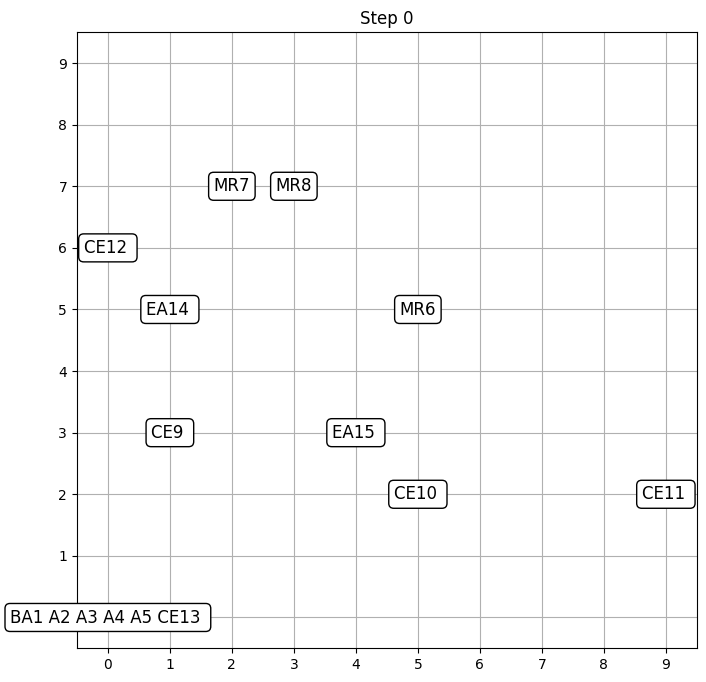

Agent 1 at position (1, 1) is of class ReativoSimples
Agent 2 at position (1, 0) is of class ReativoSimples
Agent 3 at position (1, 0) is of class ReativoSimples
Agent 4 at position (1, 1) is of class ReativoSimples
Agent 5 at position (1, 0) is of class ReativoSimples


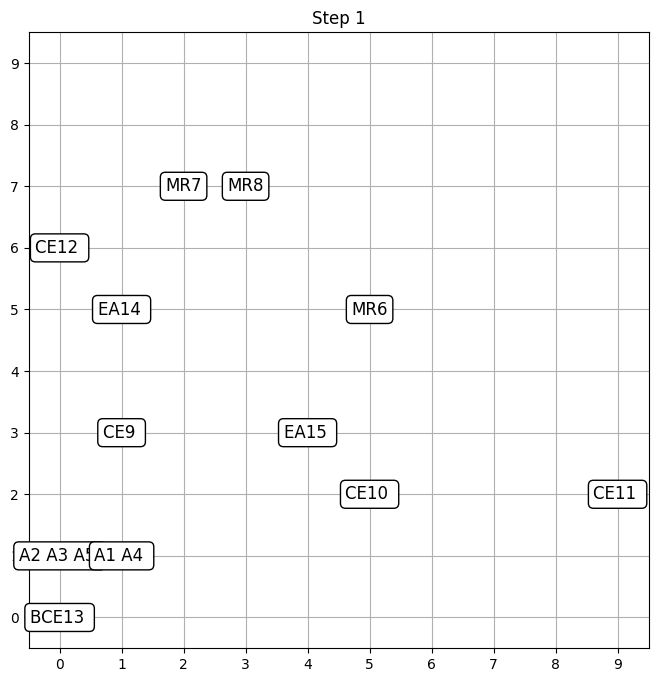

Agent 1 at position (0, 0) is of class ReativoSimples
Agent 2 at position (2, 1) is of class ReativoSimples
Agent 3 at position (1, 1) is of class ReativoSimples
Agent 4 at position (1, 0) is of class ReativoSimples
Agent 5 at position (1, 1) is of class ReativoSimples


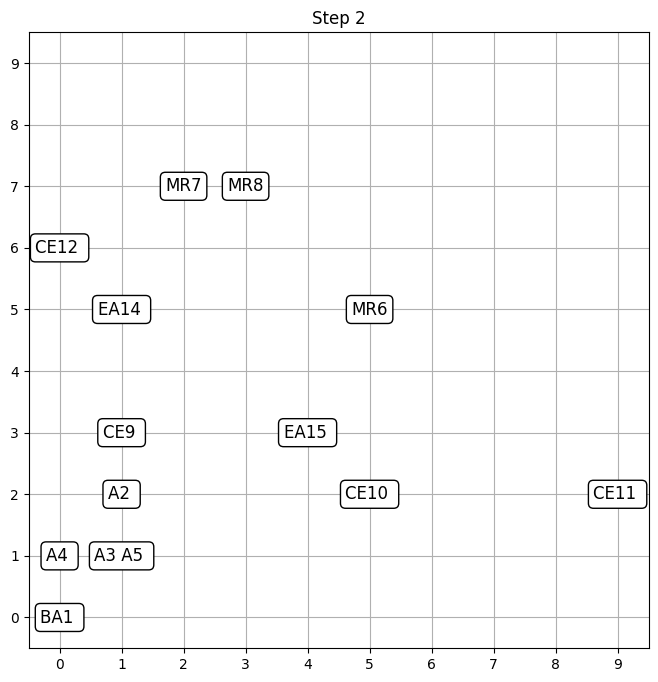

Agent 1 at position (1, 0) is of class ReativoSimples
Agent 2 at position (3, 1) is of class ReativoSimples
Agent 3 at position (2, 1) is of class ReativoSimples
Agent 4 at position (0, 0) is of class ReativoSimples
Agent 5 at position (2, 2) is of class ReativoSimples


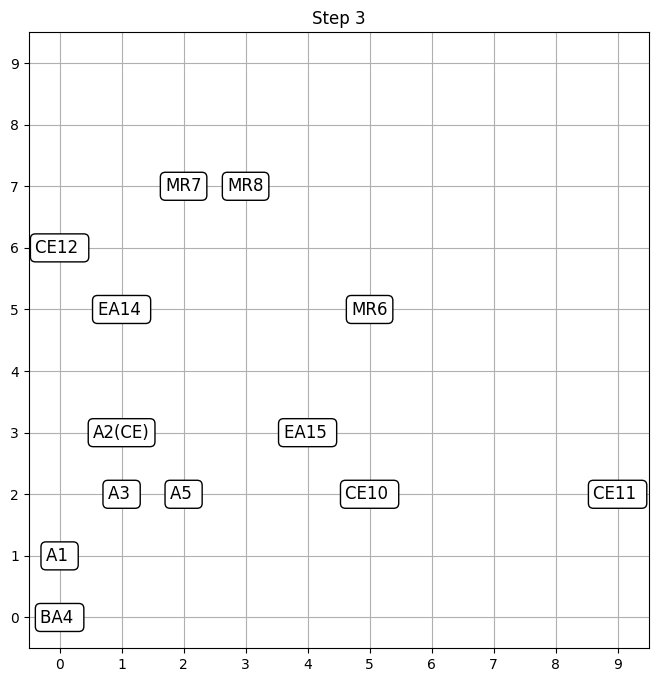

Agent 1 at position (2, 0) is of class ReativoSimples
Agent 2 at position (2, 1) is of class ReativoSimples
Agent 3 at position (2, 0) is of class ReativoSimples
Agent 4 at position (1, 1) is of class ReativoSimples
Agent 5 at position (1, 1) is of class ReativoSimples


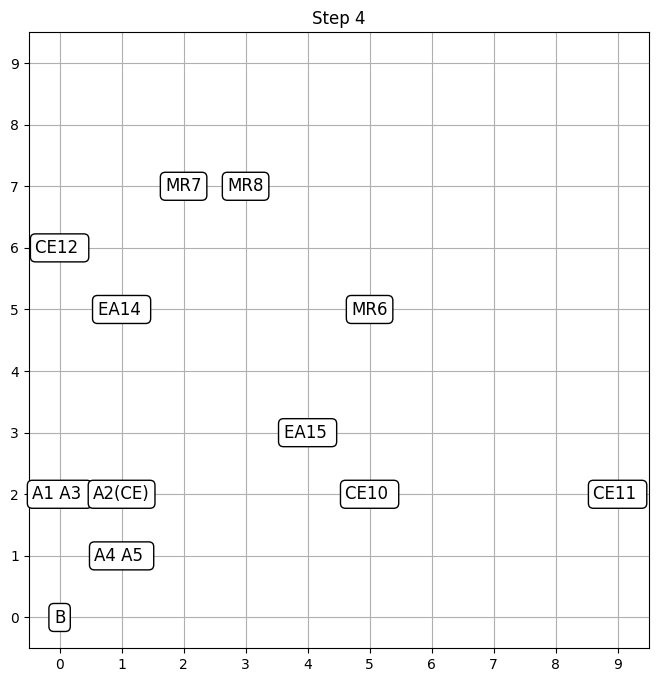

Agent 1 at position (1, 1) is of class ReativoSimples
Agent 2 at position (1, 2) is of class ReativoSimples
Agent 3 at position (1, 1) is of class ReativoSimples
Agent 4 at position (2, 2) is of class ReativoSimples
Agent 5 at position (2, 2) is of class ReativoSimples


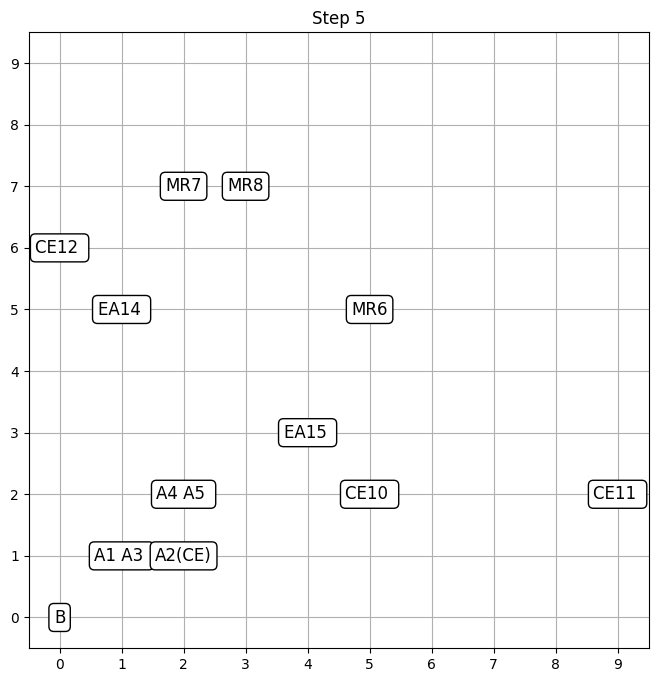

Agent 1 at position (2, 1) is of class ReativoSimples
Agent 2 at position (0, 1) is of class ReativoSimples
Agent 3 at position (0, 2) is of class ReativoSimples
Agent 4 at position (1, 1) is of class ReativoSimples
Agent 5 at position (1, 1) is of class ReativoSimples


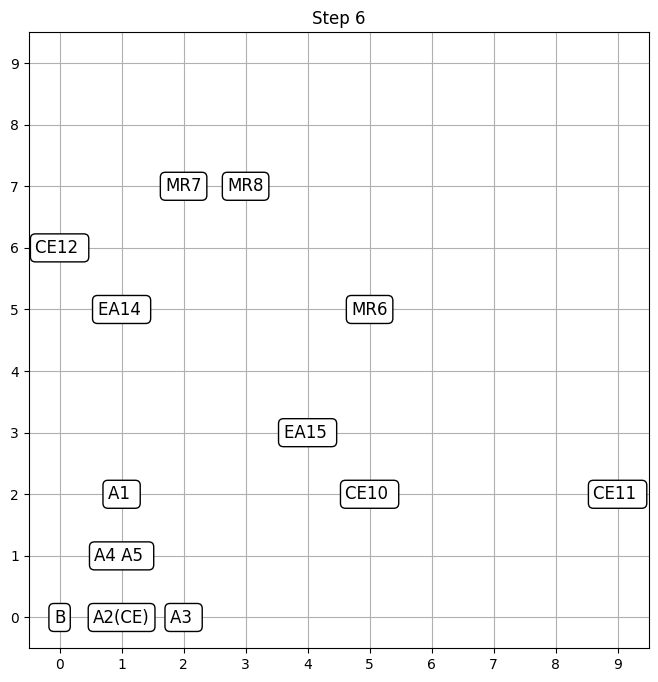

Agent 1 at position (1, 0) is of class ReativoSimples
Agent 2 at position (0, 0) is of class ReativoSimples
Agent 3 at position (1, 1) is of class ReativoSimples
Agent 4 at position (2, 0) is of class ReativoSimples
Agent 5 at position (0, 2) is of class ReativoSimples


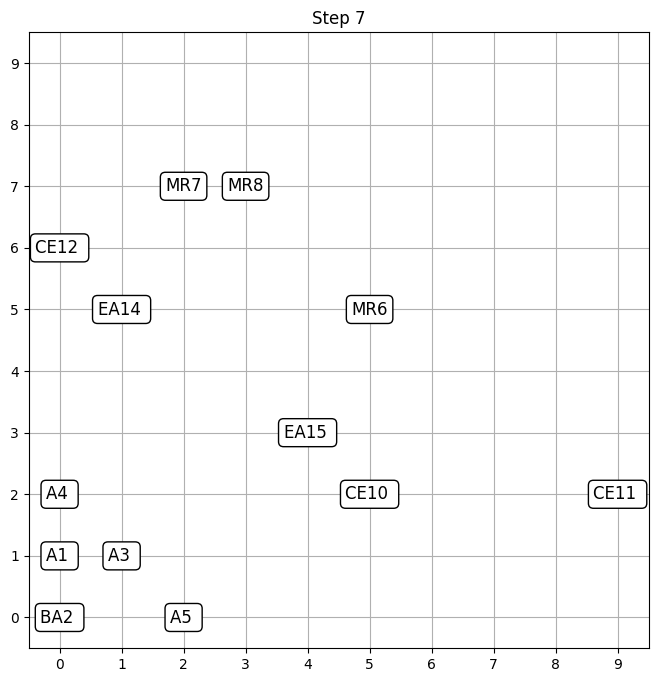

Agent 1 at position (2, 0) is of class ReativoSimples
Agent 2 at position (1, 1) is of class ReativoSimples
Agent 3 at position (1, 0) is of class ReativoSimples
Agent 4 at position (3, 1) is of class ReativoSimples
Agent 5 at position (0, 1) is of class ReativoSimples


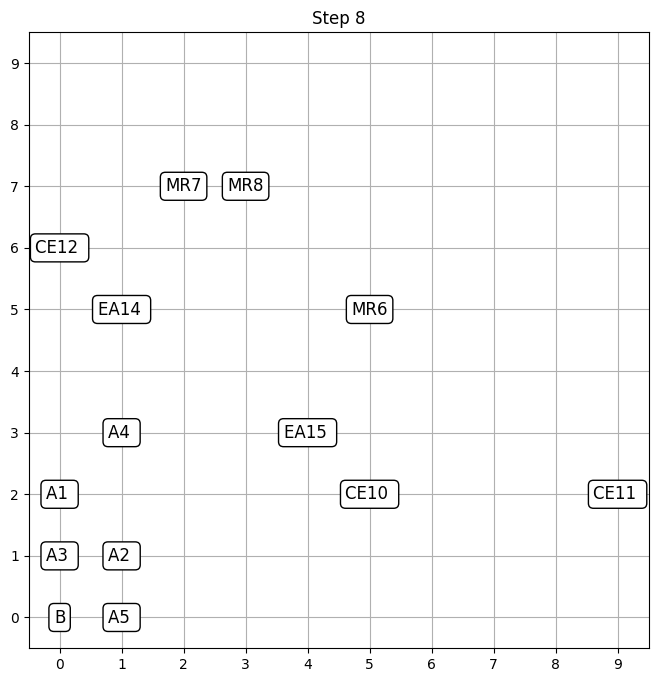

Agent 1 at position (2, 1) is of class ReativoSimples
Agent 2 at position (1, 2) is of class ReativoSimples
Agent 3 at position (2, 0) is of class ReativoSimples
Agent 4 at position (4, 1) is of class ReativoSimples
Agent 5 at position (0, 2) is of class ReativoSimples


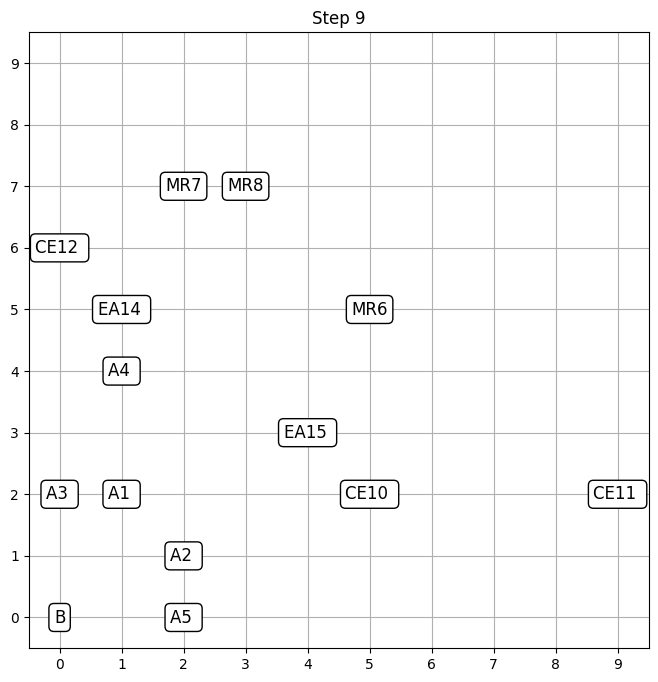

Agent 1 at position (1, 1) is of class ReativoSimples
Agent 2 at position (0, 2) is of class ReativoSimples
Agent 3 at position (2, 1) is of class ReativoSimples
Agent 4 at position (5, 1) is of class ReativoSimples
Agent 5 at position (1, 1) is of class ReativoSimples


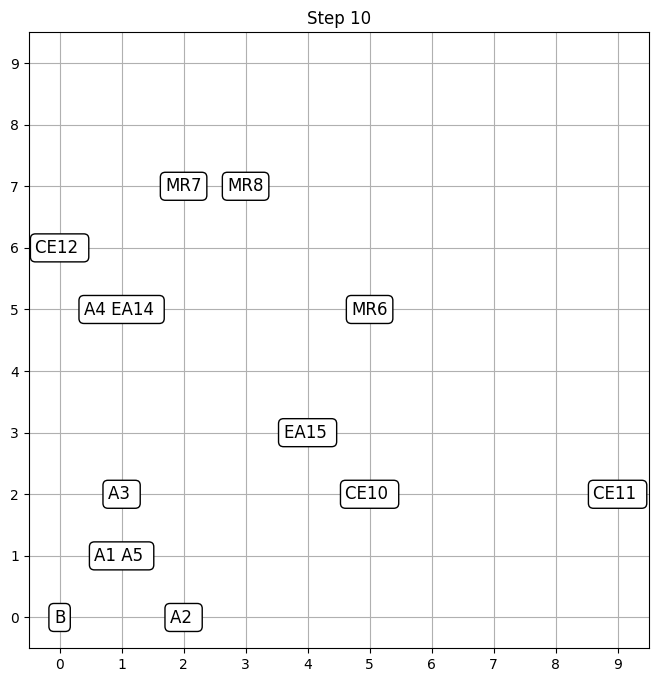

Agent 1 at position (2, 0) is of class ReativoSimples
Agent 2 at position (1, 2) is of class ReativoSimples
Agent 3 at position (3, 0) is of class ReativoSimples
Agent 4 at position (6, 0) is of class ReativoSimples
Agent 5 at position (0, 2) is of class ReativoSimples


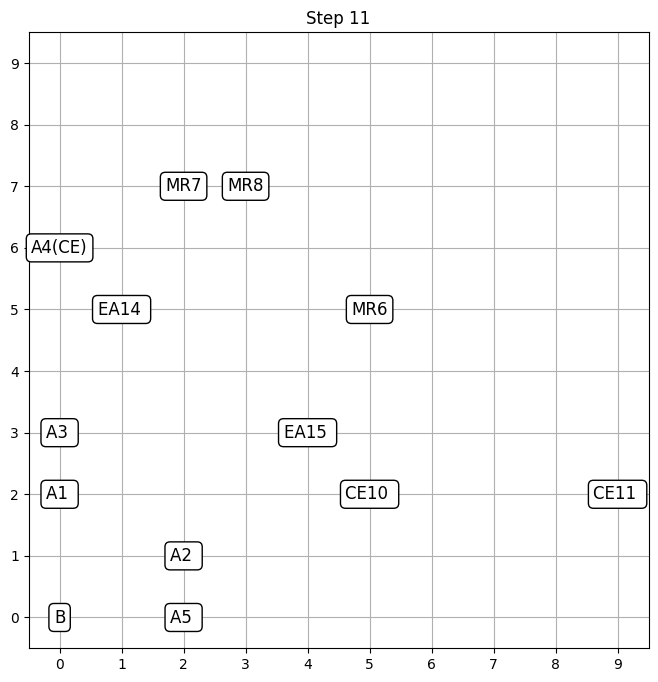

Agent 1 at position (2, 1) is of class ReativoSimples
Agent 2 at position (2, 3) is of class ReativoSimples
Agent 3 at position (2, 1) is of class ReativoSimples
Agent 4 at position (5, 1) is of class ReativoSimples
Agent 5 at position (0, 3) is of class ReativoSimples


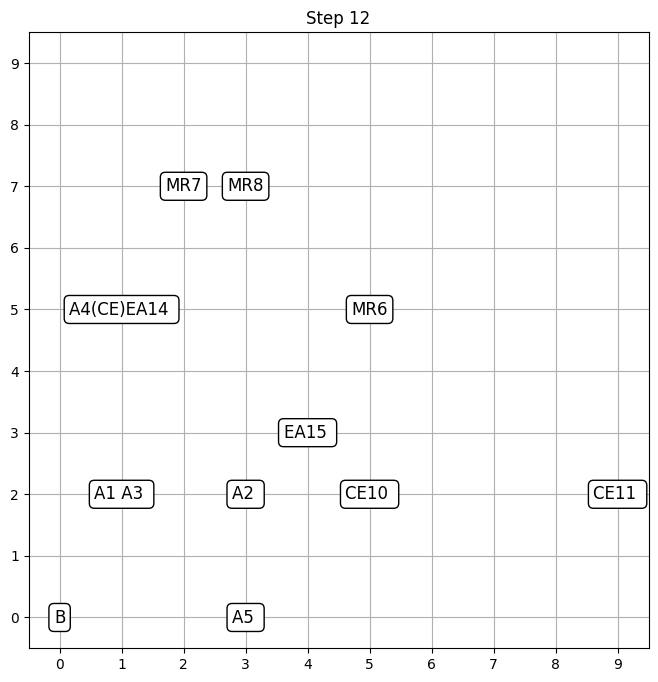

Agent 1 at position (3, 1) is of class ReativoSimples
Agent 2 at position (3, 4) is of class ReativoSimples
Agent 3 at position (3, 1) is of class ReativoSimples
Agent 4 at position (4, 1) is of class ReativoSimples
Agent 5 at position (1, 4) is of class ReativoSimples


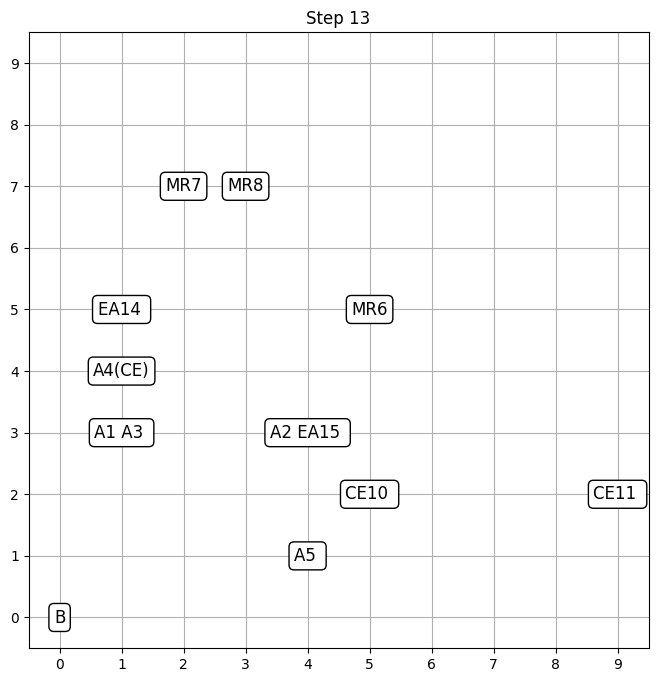

Agent 1 at position (4, 0) is of class ReativoSimples
Agent 2 at position (2, 5) is of class ReativoSimples
Agent 3 at position (2, 1) is of class ReativoSimples
Agent 4 at position (5, 0) is of class ReativoSimples
Agent 5 at position (2, 3) is of class ReativoSimples


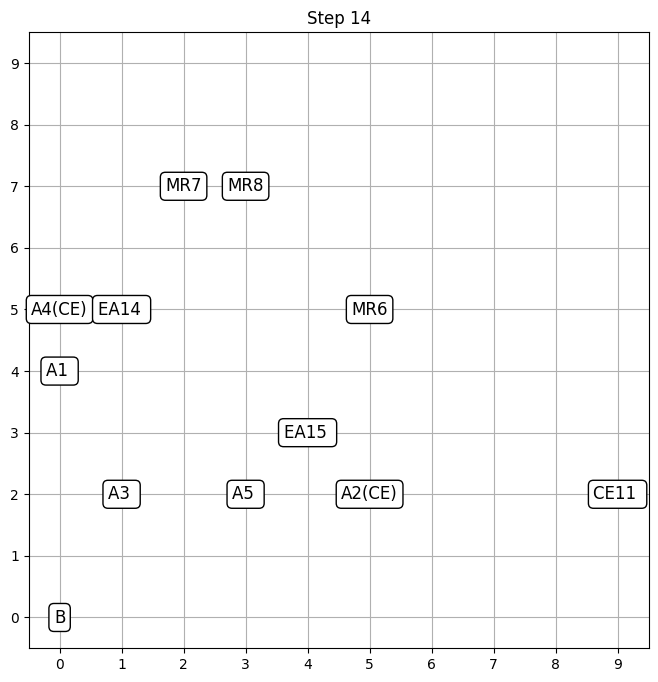

Agent 1 at position (5, 1) is of class ReativoSimples
Agent 2 at position (3, 4) is of class ReativoSimples
Agent 3 at position (3, 2) is of class ReativoSimples
Agent 4 at position (4, 0) is of class ReativoSimples
Agent 5 at position (3, 4) is of class ReativoSimples


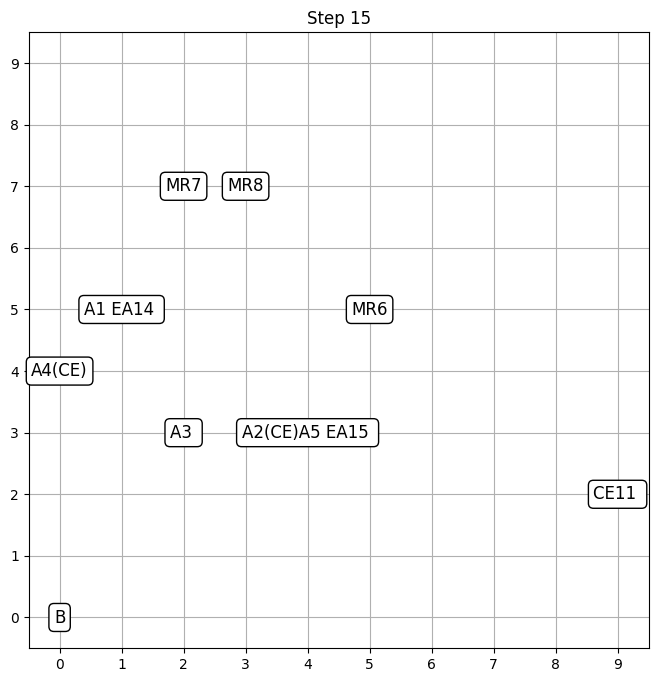

Agent 1 at position (5, 0) is of class ReativoSimples
Agent 2 at position (3, 5) is of class ReativoSimples
Agent 3 at position (4, 3) is of class ReativoSimples
Agent 4 at position (5, 0) is of class ReativoSimples
Agent 5 at position (2, 3) is of class ReativoSimples


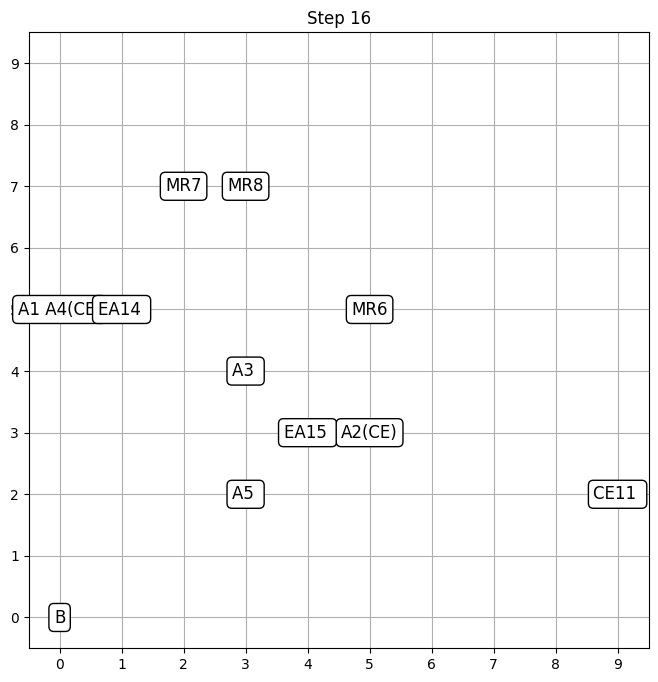

Agent 1 at position (5, 1) is of class ReativoSimples
Agent 2 at position (2, 5) is of class ReativoSimples
Agent 3 at position (3, 4) is of class ReativoSimples
Agent 4 at position (4, 0) is of class ReativoSimples
Agent 5 at position (3, 4) is of class ReativoSimples


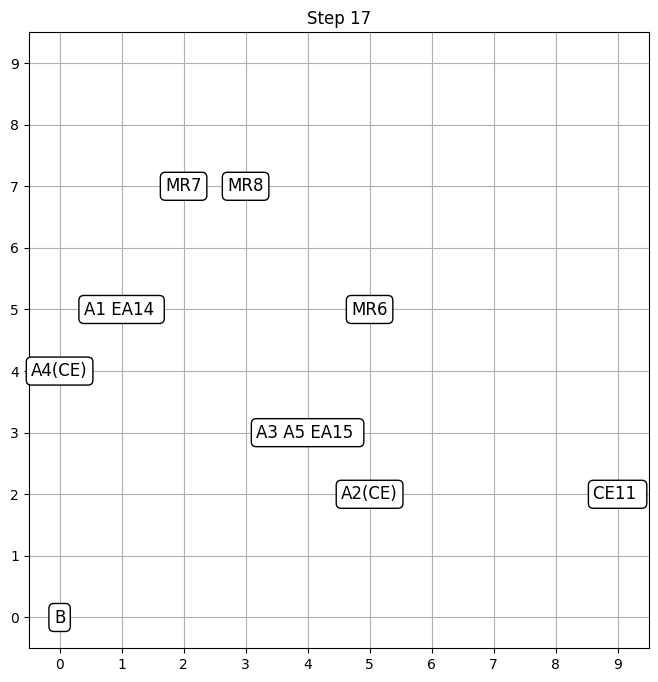

Agent 1 at position (4, 2) is of class ReativoSimples
Agent 2 at position (3, 4) is of class ReativoSimples
Agent 3 at position (2, 5) is of class ReativoSimples
Agent 4 at position (4, 1) is of class ReativoSimples
Agent 5 at position (2, 4) is of class ReativoSimples


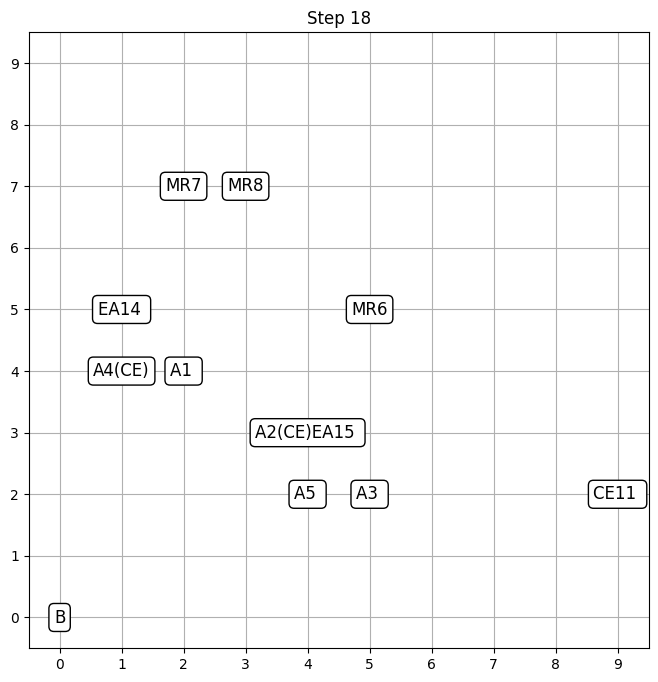

Agent 1 at position (5, 1) is of class ReativoSimples
Agent 2 at position (3, 3) is of class ReativoSimples
Agent 3 at position (3, 4) is of class ReativoSimples
Agent 4 at position (4, 0) is of class ReativoSimples
Agent 5 at position (3, 4) is of class ReativoSimples


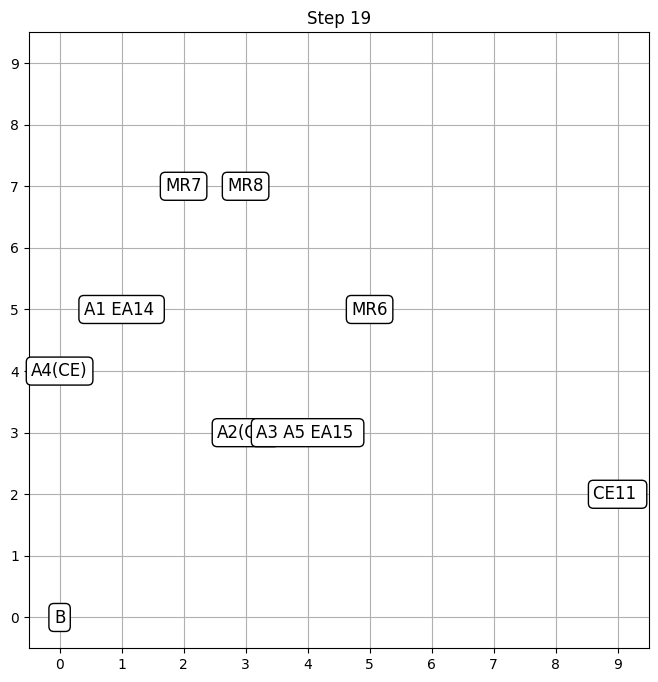

In [16]:
# Parameters
num_agents = 5
width = 10
height = 10
num_cristais = 5
num_metais = 3
num_estruturas_old = 2
num_steps = 20
base = (0, 0)

# Create the model
model = RandomWalkModel(num_agents, width, height, num_cristais, num_metais, num_estruturas_old, base)

# Run the model and visualize each step with adjustable image size
fig_width = 8  # Adjust figure width
fig_height = 8  # Adjust figure height
for step in range(num_steps):
    visualize_model(model, step, fig_width, fig_height)
    model.step()

In [ ]:
print(f"Contribuição total: {model.contribuicao_total}")
for agent in model.schedule.agents:
    if isinstance(agent,ReativoSimples):
        print(f"Contribuição do agente {agent.unique_id}: {agent.contribuicao}")

Contribuição total: 20
Contribuição do agente 1: 10
Contribuição do agente 2: 10
Contribuição do agente 3: 0
Contribuição do agente 4: 0
Contribuição do agente 5: 0
